In [1]:
stock_name = input("Enter the stock name :")

Enter the stock name : MSFT


In [11]:
Start_date = input("Enter Start date in yyyy-mm-dd format:")
End_date = input("Enter End date in yyyy-mm-dd format:")

Enter Start date in yyyy-mm-dd format: 2010-09-21
Enter End date in yyyy-mm-dd format: 2020-09-21


In [ ]:
Time_Frame = input("Enter Time frame\n(eg:1 day as 1d \n 1 week as 1 wk \n 1month as 1mo \n 1year as 1y):")

In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_tesat_split
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim

C:\Users\VARAD\AppData\Local\Temp\ipykernel_2968\2089884917.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock_name, start=Start_date, end=End_date, interval = Time_Frame)
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open    Volume
Ticker           MSFT       MSFT       MSFT       MSFT      MSFT
Date                                                            
2010-09-21  19.136889  19.342335  19.083625  19.342335  52675700
2010-09-22  18.725998  18.999925  18.535770  18.939052  94299400
2010-09-23  18.589033  18.710779  18.535770  18.649906  46201800
2010-09-24  18.855352  18.870570  18.703170  18.748824  51948800
2010-09-27  18.817303  19.015139  18.710776  18.908613  43603300
MultiIndex([( 'Close', 'MSFT'),
            (  'High', 'MSFT'),
            (   'Low', 'MSFT'),
            (  'Open', 'MSFT'),
            ('Volume', 'MSFT')],
           names=['Price', 'Ticker'])


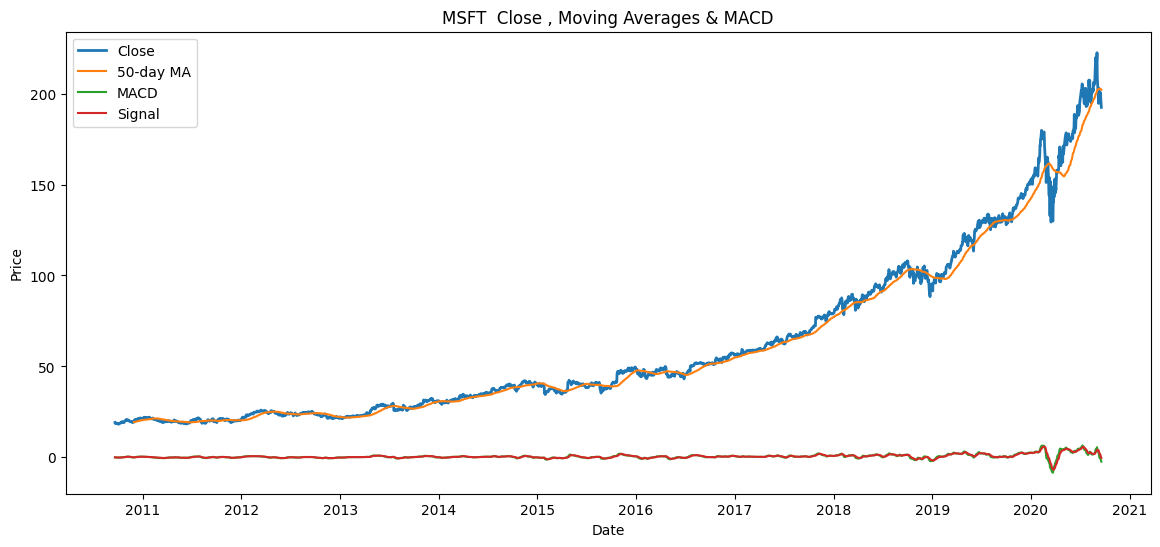

In [13]:
# Download historical data
data = yf.download(stock_name, start=Start_date, end=End_date, interval = Time_Frame)
print(data.head())
print(data.columns  )



# Calculate technical indicators
data['MA50'] = data['Close'].rolling(window=50).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()
data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA12'] - data['EMA26']
data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()



# Plot Close Price with Moving Averages & MACD
plt.figure(figsize=(14, 6))
plt.plot(data['Close'], label='Close', linewidth=2)
plt.plot(data['MA50'], label='50-day MA')
plt.plot(data['MACD'],label='MACD')
plt.plot(data['Signal'],label='Signal')

plt.title(f"{stock_name}  Close , Moving Averages & MACD")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()


In [14]:
# Drop rows with NaNs (from indicators)
data.dropna(inplace=True)

# Select features
features = data[['Close', 'MA50', 'MA200', 'EMA12', 'EMA26', 'MACD', 'Signal']]
labels = data[['Close']]

# Normalize
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_labels = scaler.fit_transform(labels)

# Create sequences
def create_sequences(features, labels, seq_length):
    X, y = [], []
    for i in range(seq_length, len(features)):
        X.append(features[i-seq_length:i])
        y.append(labels[i])
    return np.array(X), np.array(y)

seq_len = 60
X, y = create_sequences(scaled_features, scaled_labels, seq_len)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [15]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last time step
        return self.fc(out)

input_size = X_train.shape[2]
hidden_size = 64
model = LSTMModel(input_size, hidden_size)


In [16]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = loss_fn(output, y_train)
    loss.backward()
    optimizer.step()
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        val_output = model(X_test)
        val_loss = loss_fn(val_output, y_test)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}")


Epoch 1/20, Train Loss: 0.069345, Val Loss: 0.502168
Epoch 2/20, Train Loss: 0.056913, Val Loss: 0.461327
Epoch 3/20, Train Loss: 0.046013, Val Loss: 0.421445
Epoch 4/20, Train Loss: 0.036470, Val Loss: 0.381886
Epoch 5/20, Train Loss: 0.028234, Val Loss: 0.342044
Epoch 6/20, Train Loss: 0.021357, Val Loss: 0.301432
Epoch 7/20, Train Loss: 0.016018, Val Loss: 0.259927
Epoch 8/20, Train Loss: 0.012563, Val Loss: 0.218306
Epoch 9/20, Train Loss: 0.011448, Val Loss: 0.179704
Epoch 10/20, Train Loss: 0.012793, Val Loss: 0.150902
Epoch 11/20, Train Loss: 0.015239, Val Loss: 0.135847
Epoch 12/20, Train Loss: 0.016585, Val Loss: 0.132150
Epoch 13/20, Train Loss: 0.016173, Val Loss: 0.136039
Epoch 14/20, Train Loss: 0.014649, Val Loss: 0.144387
Epoch 15/20, Train Loss: 0.012856, Val Loss: 0.154801
Epoch 16/20, Train Loss: 0.011339, Val Loss: 0.165513
Epoch 17/20, Train Loss: 0.010301, Val Loss: 0.175311
Epoch 18/20, Train Loss: 0.009723, Val Loss: 0.183434
Epoch 19/20, Train Loss: 0.009488, Va

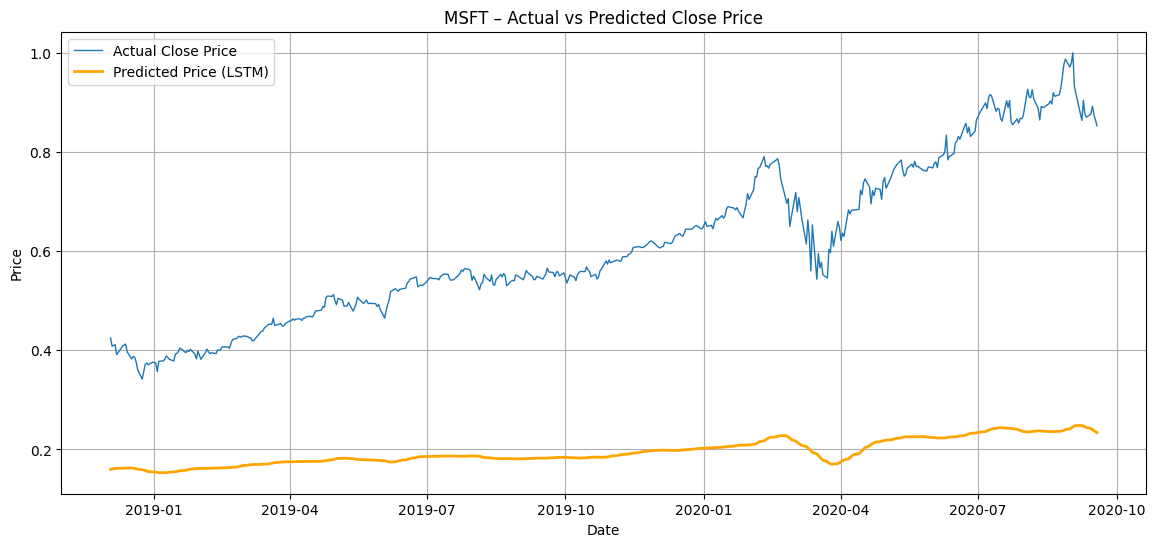

In [17]:
# Recover dates for test set
# Inverse transform predictions and actual values

# Plot
plt.figure(figsize=(14, 6))
plt.plot(data.index[-len(y_test):], y_test, label='Actual Close Price', linewidth=1)
plt.plot(data.index[-len(val_output):], val_output, label='Predicted Price (LSTM)', color='orange', linewidth=2)
plt.title(f"{stock_name} – Actual vs Predicted Close Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()



In [19]:



from sklearn.metrics import r2_score

r2 = r2_score(y_test, val_output)
print(f"R² Score: {r2:.4f}")


R² Score: -6.6257


C:\Users\VARAD\AppData\Local\Temp\ipykernel_2968\2384685478.py:45: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_actual = yf.download(stock_name, start=start_dt, end=end_dt)
[*********************100%***********************]  1 of 1 completed


Ticker            MSFT
Date                  
2020-09-21  194.519760
2020-09-22  199.206467
2020-09-23  192.646942
2020-09-24  195.143982
2020-09-25  199.590637
2020-09-28  201.146484
2020-09-29  199.052841
2020-09-30  202.001282
2020-10-01  204.046951
2020-10-02  198.025208
2020-10-05  202.049271
2020-10-06  197.756317
2020-10-07  201.521103
2020-10-08  202.241364
2020-10-09  207.264282
         Date  Predicted_Close
0  2020-09-19        65.982784
1  2020-09-20        60.166646
2  2020-09-21        53.754239
3  2020-09-22        48.253848
4  2020-09-23        44.025523
5  2020-09-24        40.969130
6  2020-09-25        38.844084
7  2020-09-26        37.405666
8  2020-09-27        36.451237
9  2020-09-28        35.827925
10 2020-09-29        35.426290
11 2020-09-30        35.170583
12 2020-10-01        35.009576
13 2020-10-02        34.909265
14 2020-10-03        34.847413


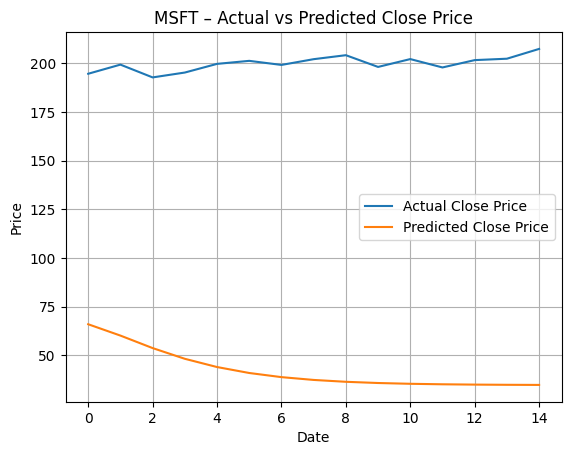

In [20]:
model.eval()
from datetime import datetime, timedelta

# Get last 60 rows from scaled feature set
last_seq = scaled_features[-60:]  # shape (60, 7) if 7 features
predicted_scaled = []

# Convert to torch tensor (1, 60, feature_size)
current_seq = torch.tensor(last_seq, dtype=torch.float32).unsqueeze(0)

for _ in range(15):
    with torch.no_grad():
        # Predict next day's scaled 'Close' price
        next_price_scaled = model(current_seq).item()
        predicted_scaled.append(next_price_scaled)

        # Create next input row (only predicted Close, other features = 0)
        next_row = np.zeros((features.shape[1],))
        next_row[0] = next_price_scaled  # Predicted 'Close'

        # Roll the window
        current_seq_np = current_seq.squeeze(0).numpy()
        current_seq_np = np.vstack([current_seq_np[1:], next_row])
        current_seq = torch.tensor(current_seq_np, dtype=torch.float32).unsqueeze(0)


# Rebuild feature array with dummy values for inverse transform
pred_scaled_arr = np.array(predicted_scaled).reshape(-1, 1)
pad = np.zeros((15, features.shape[1] - 1))  # other feature = 0
pred_full_scaled = np.concatenate([pred_scaled_arr, pad], axis=1)

# Inverse transform to get real price
predicted_15_prices = scaler.inverse_transform(pred_full_scaled)[:, 0]

# print("Predicted Close Prices for Next 15 Days:")
# for i, price in enumerate(predicted_15_prices, start=1):
#     print(f"Day {i}: {price:.2f}")

last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=15)

start_dt = datetime.strptime(End_date, '%Y-%m-%d')
end_dt = start_dt + timedelta(days=20)

df_actual = yf.download(stock_name, start=start_dt, end=end_dt)
# ,'Actual_close':df_actual[['close']]}

print(df_actual['Close'])

# Combine and display
pred_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': predicted_15_prices})
print(pred_df)
# Reset index so positions align
df_actual = df_actual.reset_index(drop=True)

# Drop NaNs and get their indices
valid_indices = df_actual['Close'].dropna().index

# Filter both actual and predicted
actual_prices = df_actual.loc[valid_indices, 'Close'].values
predicted_prices = np.array(predicted_15_prices)[valid_indices]

# plt.figure(figsize=(14, 6))
plt.plot(actual_prices, label='Actual Close Price')
plt.plot(predicted_prices, label='Predicted Close Price')
plt.title(f"{stock_name} – Actual vs Predicted Close Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()
